In [1]:
from collections import deque
import time                  

import gym
import numpy as np
import torch.nn as nn
import torch.functional as F
from skimage import transform
from vizdoom import DoomGame
import matplotlib.pyplot as plt

In [22]:
def create_enviorment():
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.init()
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    actions = [left, right, shoot]
    return game, actions

In [23]:
game, actions = create_enviorment()
game.new_episode()
state = game.get_state()
variables = state.game_variables
frame = state.screen_buffer
game.close()

In [24]:
def preprocess_frame(frame):
    preprocessed_frame = frame.astype(np.float32)
    preprocessed_frame = preprocessed_frame[30:-20, 30:-30]
    preprocessed_frame /= 255.0
    preprocessed_frame = transform.resize(preprocessed_frame, [84, 84])
    return preprocessed_frame

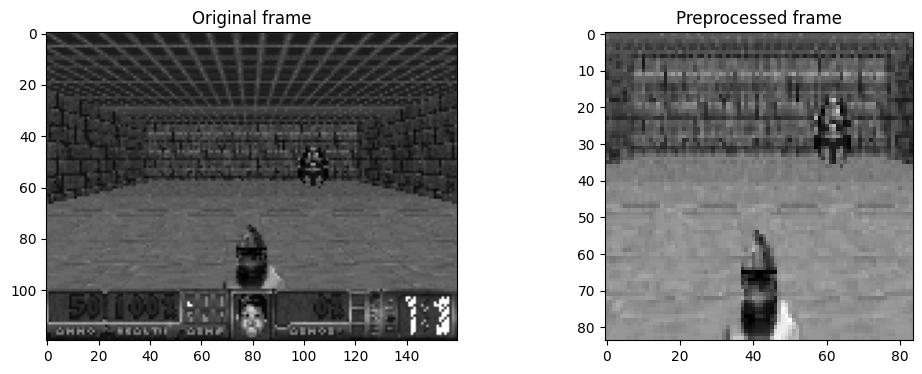

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(frame, cmap='gray')
ax[0].set_title('Original frame')
ax[1].imshow(preprocess_frame(frame), cmap='gray')
ax[1].set_title('Preprocessed frame')
plt.show()

In [26]:
stack_size = 4

def frame_stack_factory():
    return deque([np.zeros((84, 84), dtype=np.uint8) for i in range(4)], maxlen=stack_size)

frame_stack = frame_stack_factory()

def stack_frames(frame, is_new_episode):
    global frame_stack
    
    if is_new_episode:
        frame_stack = frame_stack_factory()
        for _ in range(stack_size):
            frame_stack.append(frame)
    else:
        frame_stack.append(frame)
        
    return np.stack(frame_stack, axis=0)